[<img src="https://gitlab.irit.fr/toc/etu-n7/controle-optimal/-/raw/master/ressources/Logo-toulouse-inp-N7.png" alt="N7" height="100"/>](https://gitlab.irit.fr/toc/etu-n7/controle-optimal)

# Calcul de dérivées

- Date : 2025
- Durée approximative : 1h15

## Introduction

Il existe plusieurs façon de calculer une dérivée sur un calculateur : 

- par différences finies;
- par différentiation complexe;
- en utilisant la différentiation automatique;
- en utilisant le calcul formel et un générateur de code.

Nous allons étudier ici quelques cas.

On notera $\Vert{\cdot}\Vert$ la norme euclidienne usuelle et $\mathcal{N}(0,1)$ une variable aléatoire Gaussienne centrée réduite.

In [21]:
using Pkg
Pkg.add("DualNumbers")

# load packages
using DualNumbers
using DifferentialEquations
using ForwardDiff
using LinearAlgebra
using Plots
using Plots.Measures
using Printf

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


## Dérivées par différences finies avant

Soit $f$ une fonction lisse de $\mathbb{R}^{n}$ dans $\mathbb{R}^{m}$, $x$ un point de $\mathbb{R}^{n}$ et $v$ un vecteur de $\mathbb{R}^{n}$. Si on note $g \colon h \mapsto f(x+hv)$, alors on a d'après la formule de Taylor-Young :
$$
    g(h) = \sum_{i=0}^{n} \frac{h^i}{i!} g^{(i)}(0) + R_n(h), \quad R_n(h) = o(h^n),
$$
ou d'après Taylor-Lagrange, 
$$
    \| R_n(h) \| \leq \frac{M_n h^{n+1}}{(n+1)!},
$$
de même, 
$$
    g(-h) = \sum_{i=0}^{n} \frac{(-h)^i}{i!} g^{(i)}(0) + R_n(h).
$$

La méthode des différences finies avants consiste à approcher la différentielle de $f$ en $x$ dans la direction $v$ par la formule suivante : 
$$
    \frac{f(x+hv) - f(x)}{h} = 
    \frac{g(h)-g(0)}{h} = g'(0) + \frac{h}{2} g^{2}(0) + \frac{h^2}{6} g^{(3)}(0) + o(h^2).
$$
L'approximation ainsi obtenue de $ g'(0) =  f'(x) \cdot v \in \mathbb{R}^m$ est d'ordre 1 si $g^{(2)}(0) \neq 0$ ou au moins d'ordre 2 sinon. 

**Remarque.** Sur machine, Les calculs se font en virgule flottante. On note epsilon machine, le plus petit nombre $\mathrm{eps}_\mathrm{mach}$ tel que $1+\mathrm{eps}_\mathrm{mach}\ne 1$. Cette quantité dépend des machines et de l'encodage des données. Pour l'optenir en `Julia` il suffit de taper `eps()`. On peut indiquer la précision numérique : `eps(Float64)` ou `eps(Float64(1))` pour les flottants codés sur 64 bits et `eps(Float32(1))` sur 32 bits.

Notons $\mathrm{num}(g,\, h)$ la valeur de $g(h)$ calculée numériquement et supposons que l'on puisse majorer l'erreur relative numérique par : 
$$
  \left\| \mathrm{num}(g,h) - g(h) \right\| := \| e_h\| \leq \mathrm{eps}_\mathrm{mach} L_f,
$$
ou $L_f$ est une constante qui dépend de la valeur de $f$ sur le domaine d'intérêt. Ainsi on a : 
\begin{align*}
    \left\| \frac{\mathrm{num}(g,h) - \mathrm{num}(g,0)}{h} - g'(0) \right\|
    &= \left\| \frac{g(h) + e_h - g(0) - e_0}{h} - g'(0) \right\|, \\[1em]
    &= \left\| \frac{R_1(h)}{h} + \frac{e_h - e_0}{h} \right\|, \\[1em]
    &\leq \left\| \frac{R_1(h)}{ h} \right\| + \left\| \frac{e_h - e_0}{h} \right\|, \\[1em]
    & \leq 
    \underbrace{ \frac{M_1 h}{2}}_{{\text{Erreur  d'approximation}}} +  
    \underbrace{2 \frac{\mathrm{eps}_\mathrm{mach}L_f}{h}}_{{\text{Erreur numérique}}}.
\end{align*} 
Le majorant trouvé atteint son minimum en 
$$
    h_{*} = 2 \sqrt{\frac{\mathrm{eps}_\mathrm{mach} L_f }{M_1}}.
$$

En considérant que $L_f \simeq M_1$, alors le choix se révélant le plus optimal est 
$$
    h_{*} \approx \sqrt{\mathrm{eps}_\mathrm{mach}}.
$$

## Dérivées par différences finies centrées

On peut utiliser un schéma de différences finies centrée pour calculer la dérviée de $g$. 
$$
    \frac{f(x+hv) - f(x-hv)}{2h} = \frac{g(h) - g(-h)}{2h} = 
    g'(0) + g^{(3)}(0) \frac{h^2}{6}  + \mathcal{O}(h^4),
$$
l'approximation ainsi obtenue de $f'(x) \cdot v \in \mathbb{R}^{m}$ est d'ordre 2 si $g^{(3)}(0) \neq 0$ ou au moins d'ordre 4 sinon. À noter que ce schéma nécessite plus d'évaluations de la fonction $f$. On peut montrer comme précédemment que le meilleur $h$  est de l'ordre 
$$
    h_* \approx \sqrt[3]{\mathrm{eps}_\mathrm{mach}}.
$$

## Dérivées par différentiation complexe

Les formules des schémas avant et centrée sont sensibles aux calculs de la différence $\Delta f = f(x+h) - f(x)$ ou $\Delta f = f(x+h) - f(x-h)$. Pour remédier à ce problème, les [différences finies à pas complexe](https://dl.acm.org/doi/10.1145/838250.838251) ont été introduites.
Si on suppose que la fonction $g$ est holomorphe,  c'est-à-dire dérivable au sens complexe,
on peut considérer un pas complexe $ih$. Un développement limité de $g$ en $0$ s'écrit

$$
    f(x+ih v) = g(ih) = g(0) + ih g'(0) - \frac{h^2}{2} g^{(2)}(0) - i\frac{h^3}{6} g^{(3)}(0) + o(h^3),
$$

On considère alors l'approximation : 

$$
    f'(x) \cdot v = g'(0)  \approx \frac{\mathrm{Im}(f(x+ihv))}{h}.
$$

On peut prouver que l'approximation ci-dessus est au moins d'ordre 2 et aussi démontrer que tout pas inférieur à $h_*$ est optimal, avec 
$$
    h_{*} \approx \sqrt{\mathrm{eps}_{\mathrm{mach}}}.
$$

**Remarque.** Utiliser en `Julia` la commande `imag` pour calculer la partie imaginaire d'un nombre complexe et la variable `im` pour représenter l'unité imaginaire.

## Dérivées par différentiation automatique via les nombres duaux

Les nombres duaux s'écrivent sous la forme $a + b\, \varepsilon$ avec $(a,b)\in \mathbb{R}^2$ et $\varepsilon^2 = 0$. Nous allons voir comment nous pouvons les utiliser pour calculer des dérivées.

Soit deux fonctions $f, g \colon \mathbb{R} \to \mathbb{R}$ dérivables, de dérivées respectives $f'$ et $g'$. On pose

$$
f(a + b\, \varepsilon) := f(a) + f'(a)\, b\, \varepsilon
$$

et

$$
g(a + b\, \varepsilon) := g(a) + g'(a)\, b\, \varepsilon.
$$

On a alors automatiquement les propriétés suivantes. Posons $d = x + \varepsilon$, alors :

- $(f + g)(d) = (f+g)(x) + (f+g)'(x) \, \varepsilon$
- $(fg)(d) = (fg)(x) + (fg)'(x) \, \varepsilon$
- $(g \circ f)(d) = (g \circ f)(x) + (g \circ f)'(x) \, \varepsilon$

Voici comment créer un nombre dual en `Julia` et récupérer les parties réelles et duales (avec ce que j'ai défini ci-dessous) :

```julia
using DualNumbers

# scalar case
d = 1 + 2ε # ou 1 + 2 * ε ou 1 + ε * 2
real(d) # 1
dual(d) # 2

# vector case
d = [1, 3] + [2, 4]ε # ou [1, 3] + [2, 4] * ε ou [1, 3] + ε * [2, 4] ou [1+2ε, 3+4ε]
real(d) # [1, 3]
dual(d) # [2, 4]
```

**Remarque.** On peut aussi utiliser le package `ForwardDiff` pour calculer des dérivées automatiquement. Il est plus performant que `DualNumbers`.

## Fonctions auxiliaires

In [22]:
# available methods
methods = (:forward, :central, :complex, :dual, :forward_ad)

# type of x or its coordinates
function mytypeof(x::Union{T, Vector{<:T}}) where T<:AbstractFloat
    return T
end

# default step value
function _step(x, v, method)
    T = mytypeof(x)
    eps_value = T isa AbstractFloat ? eps(T) : eps(1.)
    if method == :forward
        step = √(eps_value)
    elseif method == :central
        step = (eps_value)^(1/3)
    elseif method == :complex
        step = √(eps_value)
    else
        step = 0.0
    end
    step *= √(max(1., norm(x))) / √(max(1.0, norm(v)))
    return step
end

# default method value
function _method()
    return :forward 
end;

# creation of dual number ε
import Base.*
*(e::Function, x::Union{Number, Vector{<:Number}}) = e(x)
*(x::Union{Number, Vector{<:Number}}, e::Function) = e(x)
ε(x=1) = begin 
    if x isa Number
        return Dual.(0.0, x)
    else
        return Dual.(zeros(length(x)), x)
    end
end
em = ε
dual(x::Union{Dual, Vector{<:Dual}}) = dualpart.(x)
real(x::Union{Dual, Vector{<:Dual}}) = realpart.(x);

## La méthode principale pour le calcul de dérivées

La fonction `derivative` ci-dessous calcule la dérivée directionnelle

$$
    f'(x) \cdot v.
$$

In [23]:
## TO COMPLETE

# compute directional derivative
function derivative(f, x, v; method=_method(), h=_step(x, v, method))
    if method ∉ methods 
        error("Choose a valid method in ", methods)
    end
    if method == :forward
        return (f(x + h*v) - f(x)) / h # TO UPDATE
    elseif method == :central
        return (f(x + h*v) - f(x - h*v)) / (2h) # TO UPDATE
    elseif method == :complex
        return imag(f(x + im * h * v)) / h # TO UPDATE
    elseif method == :dual 
        return dual(f(x + v * em)) # TO UPDATE
    elseif method == :forward_ad
        if x isa Number
            return ForwardDiff.derivative(f, x)*v
        else
            return ForwardDiff.jacobian(f, x)*v
        end
    end
end;

In [24]:
# function to print derivative values and errors
function print_derivatives(f, x, v, sol)

    println("Hand derivative: ", sol, "\n")

    for method ∈ methods
        dfv = derivative(f, x, v, method=method)
        println("Method: ", method)
        println("   derivative: ", dfv)
        @printf("   error: %e\n", norm(dfv - sol))
        if method ∈ (:forward, :central, :complex)
            step = _step(x, v, method)
            println("   step: ", step)
            @printf("   error/step: %e\n", norm(dfv - sol) / step)
        end
        println()
    end

end;

## Exercice 1

1. Compléter la fonction `derivative` ci-dessus avec les méthodes de différences finies avant, centrée, par différentiation complexe et par différentiation automatique via les nombres duaux.
2. Exécuter le code ci-dessous et vérifier les résultats obtenus.

In [25]:
# Scalar case

# check if the derivatives are correct
f(x) = cos(x)
x    = π/4
v    = 1.0

# solution
sol  = -sin(x)*v

# print derivatives and errors for each method
print_derivatives(f, x, v, sol)

Hand derivative: -0.7071067811865475

Method: forward
   derivative: -0.7071067914366722
   error: 1.025012e-08
   step: 1.4901161193847656e-8
   error/step: 6.878742e-01

Method: central
   derivative: -0.7071067811880243
   error: 1.476819e-12
   step: 6.055454452393343e-6
   error/step: 2.438824e-07

Method: complex
   derivative: -0.7071067811865475
   error: 0.000000e+00
   step: 1.4901161193847656e-8
   error/step: 0.000000e+00

Method: dual
   derivative: -0.7071067811865475
   error: 0.000000e+00

Method: forward_ad
   derivative: -0.7071067811865475
   error: 0.000000e+00



In [26]:
# Vectorial case

# check if the derivatives are correct
f(x) = [0.5*(x[1]^2 + x[2]^2); x[1]*x[2]]
x    = [1.0, 2.0]
v    = [1.0, -1.0]

# solution
sol  = [x[1]*v[1]+x[2]*v[2], x[1]*v[2]+x[2]*v[1]]

# print derivatives and errors for each method
print_derivatives(f, x, v, sol)

Hand derivative: [-1.0, 1.0]

Method: forward
   derivative: [-0.9999999878930315, 0.9999999878930315]
   error: 1.712184e-08
   step: 1.8737218226238124e-8
   error/step: 9.137877e-01

Method: central
   derivative: [-1.0000000000174705, 1.0000000000028897]
   error: 1.770784e-11
   step: 7.614330860361763e-6
   error/step: 2.325594e-06

Method: complex
   derivative: [-1.0, 1.0]
   error: 0.000000e+00
   step: 1.8737218226238124e-8
   error/step: 0.000000e+00

Method: dual
   derivative: [-1.0, 1.0]
   error: 0.000000e+00

Method: forward_ad
   derivative: [-1.0, 1.0]
   error: 0.000000e+00



## Pas optimal

On se propose de tester pour la fonction $\cos$ aux points $x_0=\pi/3$, $x_1 = 10^6\times\pi/3$ et la fonction $\cos+10^{-8} \mathcal{N}(0, \, 1)$ au point $x_0=\pi/3$ l'erreur entre les différences finies et la dérivée au point considéré en fonction de $h$. On prendra $h=10^{-i}$ pour $i= \{1,\ldots,16\}$ et on tracera ces erreurs dans une échelle logarithmique (en `Julia`, avec le package `Plots` on  utilise l'option `scale=:log10`).

## Exercice 2

- Visualiser les différentes erreurs en fonction de $h$ pour les différentes méthodes de calcul de dérivées. Commentaires.
- Modifier la précision de $x_0$ et $x_1$ en `Float32`. Commentaires.

In [27]:
# affichage des erreurs en fonction de h
function plot_errors(steps, errors, h_star, title)

    steps_save = steps
    ymax = 10^10

    # supprimer les erreurs nulles
    non_nul_element = findall(!iszero, errors) 
    errors = errors[non_nul_element]
    steps  = steps[non_nul_element]

    # Courbe des erreurs pour les differents steps en bleu
    plt = plot((10.).^(-steps), errors, xscale=:log10, yscale=:log10, linecolor=:blue, lw=2, legend=false)

    # régler xlims pour toujours avoir tous les steps de départ
    plot!(plt, xlims=(10^(-maximum(steps_save)), 10^(-minimum(steps_save))))

    # ylims toujours entre 10^-16 et ymax
    plot!(plt, ylims=(10^(-16), ymax))

    # Ligne verticale pour situer l'erreur optimale h* en rouge
    plot!(plt,[h_star, h_star], [10^(-16), ymax], linecolor=:red, lw=1, linestyle=:dash)

    # titre de la figure et xlabel
    plot!(plt, xlabel = "h", title = title, legend=false, titlefontsize=10)

    # ajouter des marges en bas de la figure pour mieux voir le xlabel 
    plot!(plt, bottom_margin = 5mm)

    #
    return plt

end;

In [28]:
# Les differentes fonctions et la dérivée theorique
fun1(x) = cos(x)
fun2(x) = cos(x) + 1.e-8*randn()
dfun(x) = -sin(x);

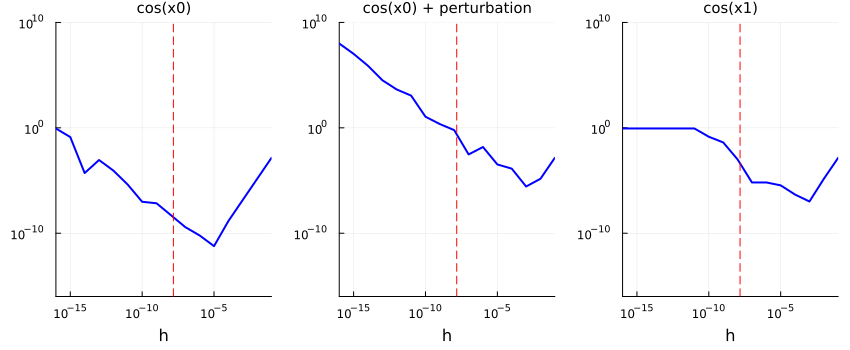

In [29]:
# method 
method = :central    # TO PLAY WITH
h_star = √(eps(1.0))  # TO UPDATE ACCORDING TO THE METHOD

# Points pour lesquels on souhaite effectuer les tests
x0 = Float64(π/3)
x1 = 1.e6*π/3

# steps pour faire les tests
steps = range(1, 16, 16)

# Initialisation des vecteurs d'erreur
err_x0  = zeros(length(steps))
err_x0p = zeros(length(steps))
err_x1  = zeros(length(steps))

# Calcul des erreurs
for i in 1:length(steps)
    h = 10^(-steps[i])
    err_x0[i]  = abs(derivative(fun1, x0, 1.0, h=h, method=method) - (dfun(x0)))
    err_x1[i]  = abs(derivative(fun1, x1, 1.0, h=h, method=method) - (dfun(x1)))
    err_x0p[i] = abs(derivative(fun2, x0, 1.0, h=h, method=method) - (dfun(x0)))
end

# Affichage des erreurs
p1 = plot_errors(steps, err_x0,  h_star, "cos(x0)")
p2 = plot_errors(steps, err_x0p, h_star, "cos(x0) + perturbation")
p3 = plot_errors(steps, err_x1,  h_star, "cos(x1)")

plot(p1, p2, p3, layout=(1,3), size=(850, 350))